In [4]:
import pandas as pd

file_path = "/content/cumulative_2025.10.04_12.53.39.csv"

with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    for _ in range(2):
        print(f.readline())


rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = "/content/cumulative_2025.10.04_12.53.39.csv"

# --- Detect header line (more flexible) ---
with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

header_line = None
for i, line in enumerate(lines):
    cleaned = line.strip().lower().replace('"', '').replace("'", '').lstrip('\ufeff')
    if cleaned.startswith('kepid') or 'kepid' in cleaned.split(','):
        header_line = i
        break

# If still not found, assume first line is header
if header_line is None:
    print("Warning: Header not detected automatically. Assuming first line is header.")
    header_line = 0

print(f"Header found at line {header_line}")

# --- Load dataset ---
df = pd.read_csv(file_path, skiprows=header_line, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns:", df.columns[:10])

# --- Drop irrelevant columns ---
drop_cols = [
    'kepid', 'kepoi_name', 'kepler_name', 'koi_comment',
    'koi_pdisposition', 'koi_disposition_prov', 'koi_tce_delivname'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# --- Ensure target exists ---
if 'koi_disposition' not in df.columns:
    raise ValueError("Column 'koi_disposition' not found.")

# --- Drop rows with missing target ---
df = df.dropna(subset=['koi_disposition'])

# Keep original class names
class_names = df['koi_disposition'].unique().tolist()
print("Class names:", class_names)

# --- Drop columns with >50% missing ---
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# --- Fill missing values ---
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# --- Encode categorical columns (EXCEPT target) ---
for col in df.select_dtypes(include=['object']).columns:
    if col != 'koi_disposition':
        df[col] = pd.factorize(df[col])[0]

# --- Split features/labels ---
X = df.drop(columns=['koi_disposition'])
y = df['koi_disposition']

# --- Scale features ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Data cleaned successfully")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# --- Save datasets ---
X_train.to_csv("kepler_X_train.csv", index=False)
X_test.to_csv("kepler_X_test.csv", index=False)
y_train.to_csv("kepler_y_train.csv", index=False)
y_test.to_csv("kepler_y_test.csv", index=False)

# --- Save class names separately ---
pd.Series(class_names).to_csv("kepler_class_names.csv", index=False)

print("All files saved successfully!")


Header found at line 0
Loaded shape: (9564, 141)
Columns: Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score',
       'koi_fpflag_nt'],
      dtype='object')
Class names: ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
Data cleaned successfully
Train shape: (7651, 115)
Test shape: (1913, 115)
All files saved successfully!


In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# --- Load Dataset ---
X_train = pd.read_csv("kepler_X_train.csv")
X_test = pd.read_csv("kepler_X_test.csv")
y_train = pd.read_csv("kepler_y_train.csv").values.ravel()
y_test = pd.read_csv("kepler_y_test.csv").values.ravel()

# --- Encode string labels into numeric classes ---
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# --- Define all models for comparison ---
models = {
    "Naive Bayes": GaussianNB(),
    "K Nearest Neighbor": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Adaboost": AdaBoostClassifier(n_estimators=100),
    "Neural Network": MLPClassifier(max_iter=1000, early_stopping=True, random_state=42),
    "XGBoost Classifier": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "LightGBM Classifier": LGBMClassifier(force_col_wise=True, verbose=-1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
}

# --- Train & Evaluate all models ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# --- Print final accuracy summary ---
print("\n===== Final Accuracy Results =====")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.2%}")


Naive Bayes: 0.8751
K Nearest Neighbor: 0.8442
Decision Tree: 0.9085
Adaboost: 0.9226
Neural Network: 0.9158
XGBoost Classifier: 0.9477
Random Forest: 0.9289
LightGBM Classifier: 0.9493
Gradient Boosting: 0.9467

===== Final Accuracy Results =====
Naive Bayes: 87.51%
K Nearest Neighbor: 84.42%
Decision Tree: 90.85%
Adaboost: 92.26%
Neural Network: 91.58%
XGBoost Classifier: 94.77%
Random Forest: 92.89%
LightGBM Classifier: 94.93%
Gradient Boosting: 94.67%


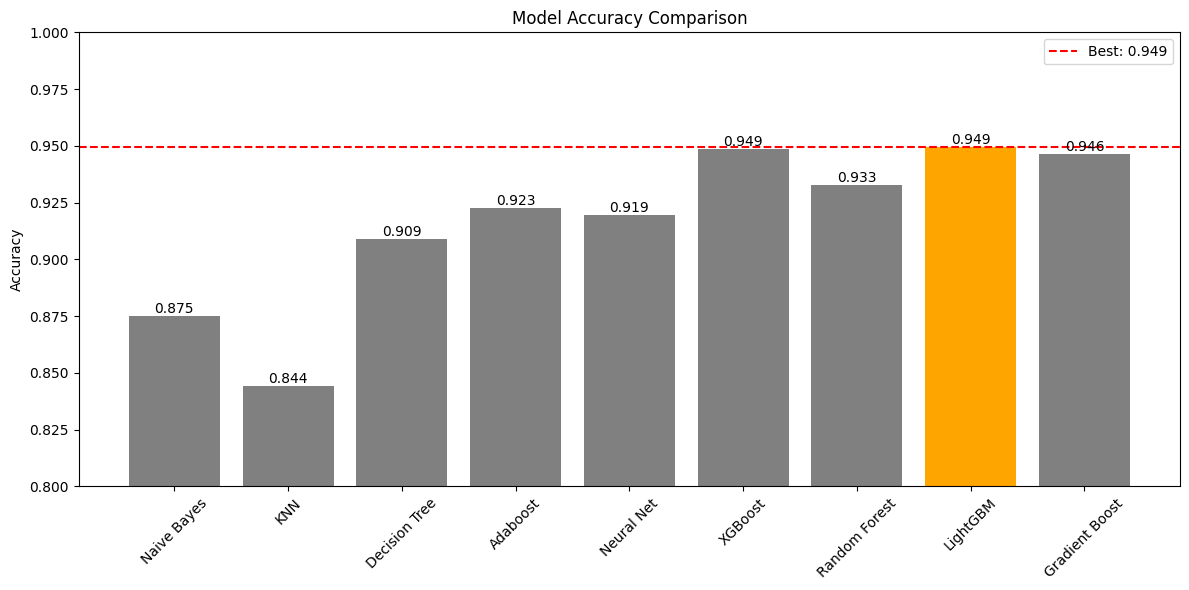

In [15]:
# --- Model accuracy results ---
results = {
    "Naive Bayes": 0.8751,
    "KNN": 0.8442,
    "Decision Tree": 0.9090,
    "Adaboost": 0.9226,
    "Neural Net": 0.9195,
    "XGBoost": 0.9488,
    "Random Forest": 0.9326,
    "LightGBM": 0.9493,
    "Gradient Boost": 0.9462
}

# --- Split keys and values ---
models = list(results.keys())
accuracies = list(results.values())

# --- Identify the best model ---
max_acc = max(accuracies)
max_index = accuracies.index(max_acc)

# --- Set colors (highlight best model) ---
colors = ["gray"] * len(models)
colors[max_index] = "orange"

# --- Plot the bar chart ---
plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracies, color=colors)

# --- Add accuracy values on top of bars ---
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{acc:.3f}",
             ha='center', va='bottom')

# --- Add line for best accuracy ---
plt.axhline(y=max_acc, color='red', linestyle='--', linewidth=1.5, label=f"Best: {max_acc:.3f}")

# --- Format and show plot ---
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


LightGBM Accuracy: 0.9488
                precision    recall  f1-score   support

     CANDIDATE       0.88      0.88      0.88       396
     CONFIRMED       0.92      0.92      0.92       549
FALSE POSITIVE       0.99      0.99      0.99       968

      accuracy                           0.95      1913
     macro avg       0.93      0.93      0.93      1913
  weighted avg       0.95      0.95      0.95      1913



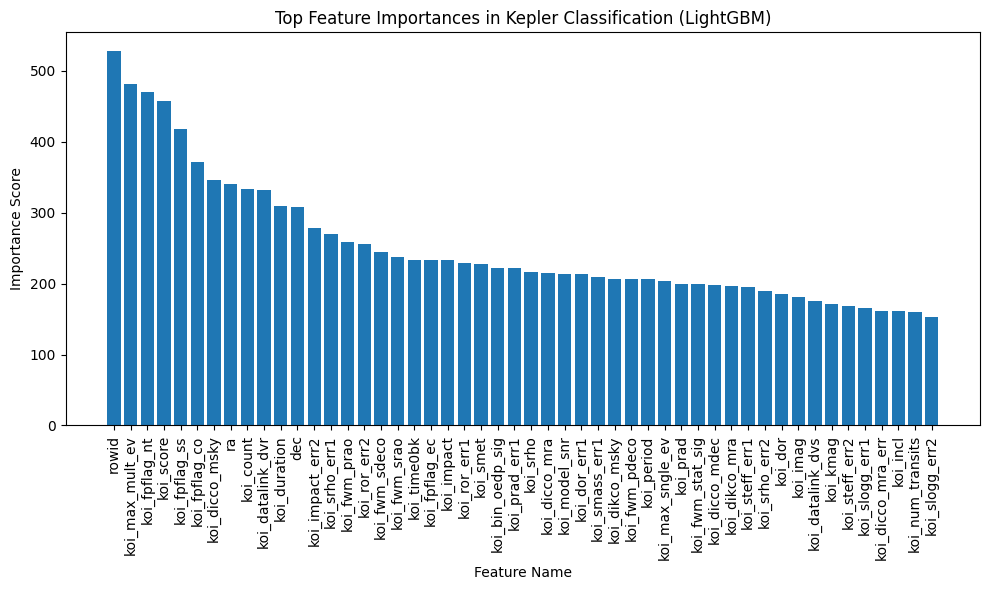

In [16]:
# --- Load the preprocessed dataset ---
X_train = pd.read_csv("kepler_X_train.csv")
X_test = pd.read_csv("kepler_X_test.csv")
y_train = pd.read_csv("kepler_y_train.csv").values.ravel()
y_test = pd.read_csv("kepler_y_test.csv").values.ravel()

# --- Train the model using LightGBM ---
model = LGBMClassifier(
    n_estimators=200,
    random_state=42,
    force_col_wise=True,
    verbose=-1
)
model.fit(X_train, y_train)

# --- Evaluate the model ---
y_pred = model.predict(X_test)
print("LightGBM Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

# --- Analyze feature importance ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 50

plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances in Kepler Classification (LightGBM)")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X_train.columns[indices[:top_n]], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# --- Load the preprocessed dataset ---
X_train = pd.read_csv("kepler_X_train.csv")
X_test = pd.read_csv("kepler_X_test.csv")
y_train = pd.read_csv("kepler_y_train.csv").values.ravel()
y_test = pd.read_csv("kepler_y_test.csv").values.ravel()

# --- Train the model using LightGBM ---
model = LGBMClassifier(
    n_estimators=200,
    random_state=42,
    force_col_wise=True,
    verbose=-1
)
model.fit(X_train, y_train)

# --- Get top 50 important features ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 50
top_features = X_train.columns[indices[:top_n]]

# --- Save new datasets with only top 50 features ---
X_train_top50 = X_train[top_features]
X_test_top50 = X_test[top_features]

X_train_top50.to_csv("kepler_X_train_top50.csv", index=False)
X_test_top50.to_csv("kepler_X_test_top50.csv", index=False)

print("SAVED --> kepler_X_train_top50.csv && kepler_X_test_top50.csv")


SAVED --> kepler_X_train_top50.csv && kepler_X_test_top50.csv


In [27]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Load the "Top 50" datasets ---
X_train_top50 = pd.read_csv("kepler_X_train_top50.csv")
X_test_top50 = pd.read_csv("kepler_X_test_top50.csv")
y_train = pd.read_csv("kepler_y_train.csv").values.ravel()
y_test = pd.read_csv("kepler_y_test.csv").values.ravel()

# --- Train the model again using only Top 50 features ---
model_top50 = LGBMClassifier(
    n_estimators=200,
    random_state=42,
    force_col_wise=True,
    verbose=-1
)
model_top50.fit(X_train_top50, y_train)

# --- Evaluate the new model ---
y_pred_top50 = model_top50.predict(X_test_top50)
print("LightGBM Accuracy (Top 50 features):", round(accuracy_score(y_test, y_pred_top50), 4))
print(classification_report(y_test, y_pred_top50))


LightGBM Accuracy (Top 50 features): 0.9493
                precision    recall  f1-score   support

     CANDIDATE       0.89      0.87      0.88       396
     CONFIRMED       0.92      0.93      0.92       549
FALSE POSITIVE       0.99      0.99      0.99       968

      accuracy                           0.95      1913
     macro avg       0.93      0.93      0.93      1913
  weighted avg       0.95      0.95      0.95      1913



In [29]:
import joblib

joblib.dump(model_top50, "lightgbm_top50_model.pkl")
print("SAVED --> lightgbm_top50_model.pkl")

SAVED --> lightgbm_top50_model.pkl


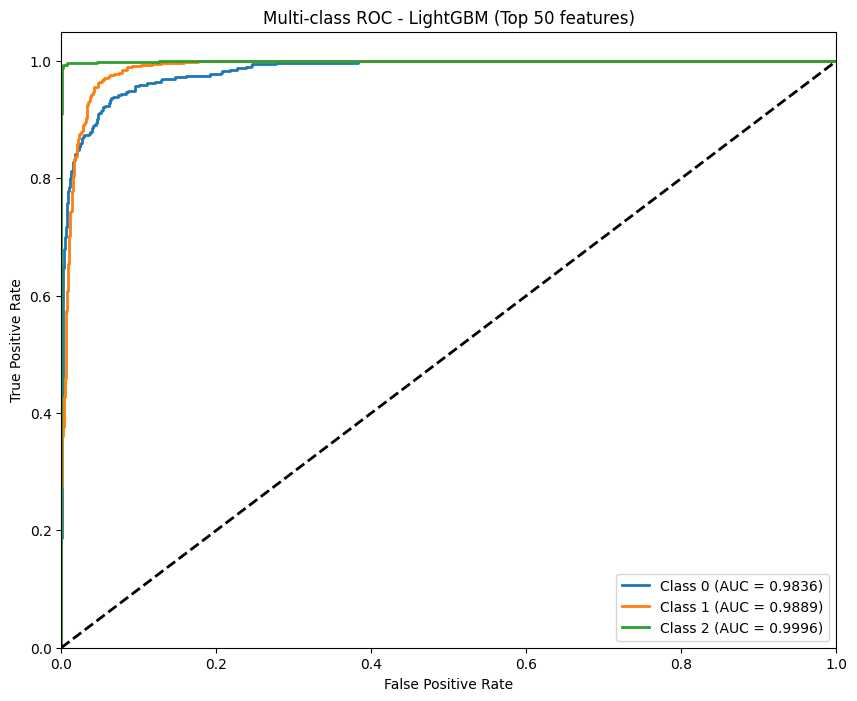

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

y_score = model_top50.predict_proba(X_test_top50)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC - LightGBM (Top 50 features)')
plt.legend(loc="lower right")
plt.show()


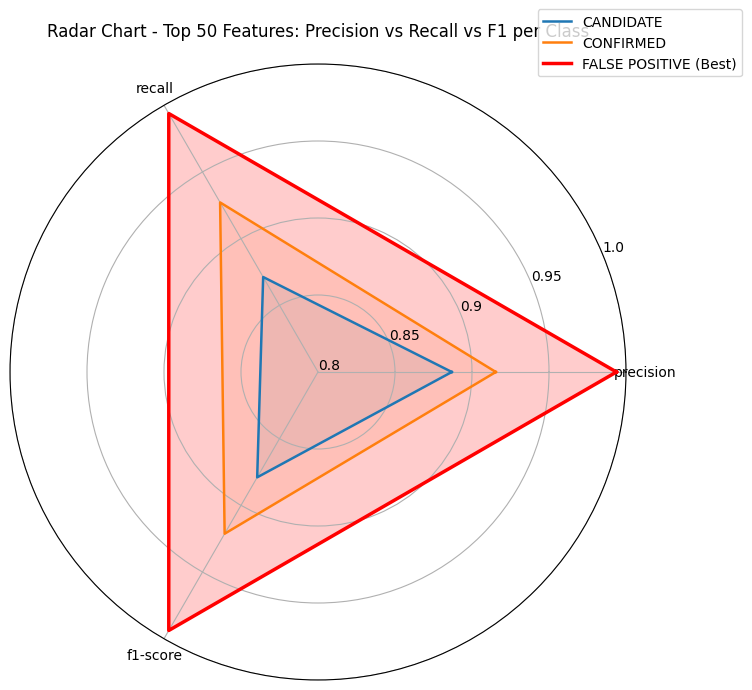

In [33]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- Get predictions for the Top 50 model ---
y_pred_top50 = model_top50.predict(X_test_top50)

# --- Extract classification report as a dictionary ---
report = classification_report(y_test, y_pred_top50, output_dict=True)

# --- Select only the classes ---
classes = [cls for cls in report.keys() if cls not in ('accuracy', 'macro avg', 'weighted avg')]
metrics = ['precision', 'recall', 'f1-score']
data = [[report[cls][m] for m in metrics] for cls in classes]

# --- Identify the best class based on F1-score ---
f1_scores = [report[cls]['f1-score'] for cls in classes]
best_class_index = int(np.argmax(f1_scores))
best_class = classes[best_class_index]

# --- Define the angles for the radar chart ---
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# --- Create the radar chart ---
plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)

# Set Y-axis range for better visibility
ax.set_ylim(0.8, 1.0)
ax.set_yticks([0.8, 0.85, 0.9, 0.95, 1.0])
ax.set_yticklabels(["0.8", "0.85", "0.9", "0.95", "1.0"])

# --- Plot each class ---
for i, cls in enumerate(classes):
    values = data[i]
    values += values[:1]  # Close the loop for each class

    if cls == best_class:
        ax.plot(angles, values, linewidth=2.5, color='red', label=f"{cls} (Best)")
        ax.fill(angles, values, color='red', alpha=0.2)
    else:
        ax.plot(angles, values, linewidth=1.8, label=cls)
        ax.fill(angles, values, alpha=0.1)

# Customize plot style
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Radar Chart - Top 50 Features: Precision vs Recall vs F1 per Class", pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


[learning_curve] Training set sizes: [ 765 1912 3060 3825]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.9s finished


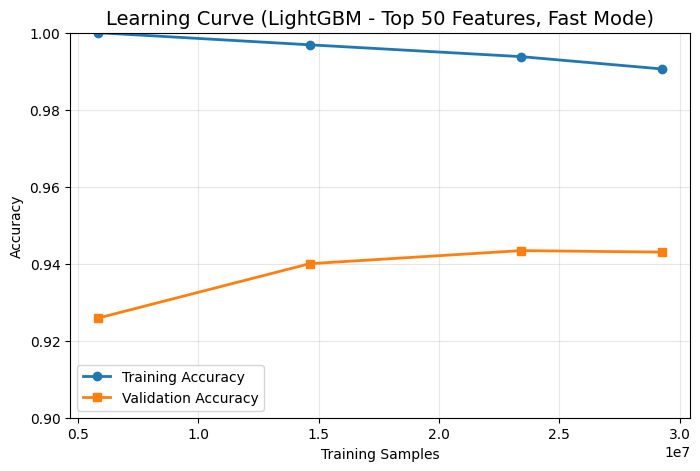

In [35]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

# --- Ultra-light version of the model for Top 50 features ---
model_lc_top50 = LGBMClassifier(
    n_estimators=50,       # Reduced number of estimators
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

# --- Faster Learning Curve on Top 50 features ---
train_sizes, train_scores, val_scores = learning_curve(
    model_lc_top50, X_train_top50, y_train,
    cv=2,                                 # Reduced from 3 to 2
    scoring='accuracy',
    train_sizes=[0.2, 0.5, 0.8, 1.0],     # Only 4 points
    n_jobs=-1,
    verbose=1
)

# --- Compute mean scores ---
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# --- Plot the learning curve ---
plt.figure(figsize=(8, 5))
plt.plot(train_sizes * len(X_train_top50), train_mean, marker='o', linewidth=2, label="Training Accuracy")
plt.plot(train_sizes * len(X_train_top50), val_mean, marker='s', linewidth=2, label="Validation Accuracy")
plt.title("Learning Curve (LightGBM - Top 50 Features, Fast Mode)", fontsize=14)
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# === 0) Model Prediction (LightGBM) ===
y_pred = model.predict(X_test)  # Change this if your model name is different

# Ensure y_pred is encoded to match y_test_enc
if isinstance(y_pred[0], str):
    y_pred_enc = label_encoder.transform(y_pred)
else:
    y_pred_enc = y_pred


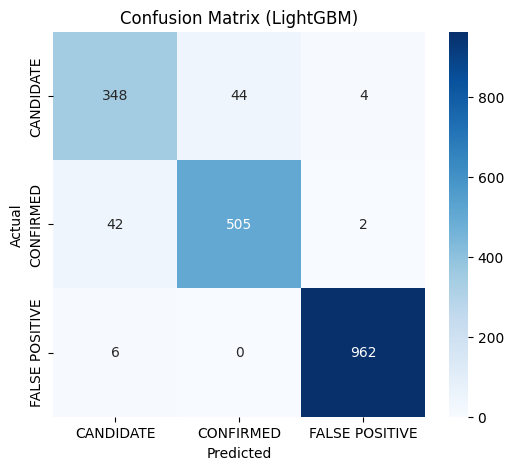

In [37]:
# === 1) Classification Report ===
report = classification_report(y_test_enc, y_pred_enc, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3]  # نحذف accuracy/macro/weighted لو مش محتاجينهم

# === 2) Confusion Matrix ===
cm = confusion_matrix(y_test_enc, y_pred_enc, labels=[0,1,2])  # غيّر لو الكلاسات غير 0/1/2

# === 3) Plot Confusion Matrix ===
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (LightGBM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<Figure size 800x500 with 0 Axes>

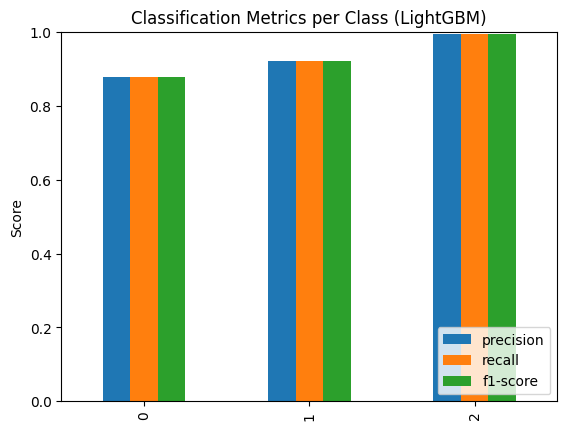

In [38]:
# === 4) Plot Classification Metrics ===
plt.figure(figsize=(8,5))
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("Classification Metrics per Class (LightGBM)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

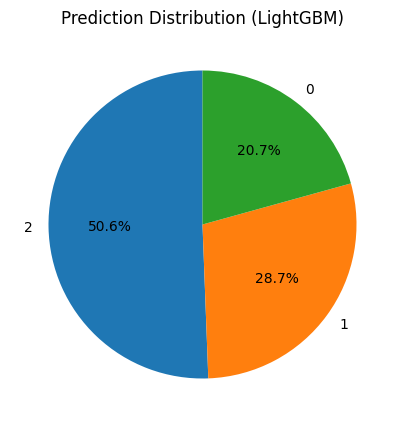

In [39]:
# === 5) Plot Prediction Distribution ===
plt.figure(figsize=(5,5))
pd.Series(y_pred_enc).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Prediction Distribution (LightGBM)")
plt.ylabel("")
plt.show()